# Titanic ML competition

https://www.kaggle.com/competitions/titanic/

In [36]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn import svm

from xgboost.sklearn import XGBClassifier

import importlib
import auxiliary as aux


In [2]:
train = pd.read_csv(Path('train.csv'))
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
train.head(3)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


**Data Definitions**

- survived: 0 = No, 1 = Yes
- pclass: 	Ticket class 	1 = 1st, 2 = 2nd, 3 = 3rd
- sex: 	Sex 	
- Age: 	Age in years 	
- sibsp: 	# of siblings / spouses aboard the Titanic 	
- parch: 	# of parents / children aboard the Titanic 	
- ticket: 	Ticket number 	
- fare: 	Passenger fare 	
- cabin: 	Cabin number 	
- embarked: 	Port of Embarkation 	C = Cherbourg, Q = Queenstown, S = Southampton

In [4]:
# Get labels
y = train['Survived']


### Baseline Model

We'll start with just a few features for the baseline model.

In [5]:
# Select features
features = ["Pclass", "Sex", "SibSp", "Parch", "Age"]
num_features = ['Age']
cat_features = [f for f in features if f not in num_features]

# Check fraction of nulls
train[features].isnull().mean()


Pclass    0.000000
Sex       0.000000
SibSp     0.000000
Parch     0.000000
Age       0.198653
dtype: float64

Rather than dealing with the Age nulls now, let's choose a simpler feature set for the baseline model and address the nulls later.

In [6]:
# Select features
features = ["Pclass", "Sex", "SibSp", "Parch"]
num_features = []
cat_features = [f for f in features if f not in num_features]

# Check fraction of nulls
train[features].isnull().mean()


Pclass    0.0
Sex       0.0
SibSp     0.0
Parch     0.0
dtype: float64

In [7]:
# Test train split
X_train, X_test, y_train, y_test = train_test_split(
    train[features], y, test_size=0.2, random_state=42)


In [8]:
ohe = ColumnTransformer([
    ('ohe_features', OneHotEncoder(handle_unknown='ignore'), cat_features),
    ('scaled_num', StandardScaler(), num_features)
])

lr_pipe = Pipeline([('ohe', ohe),
                    ('lr', LogisticRegression())])

lr_pipe.fit(X_train, y_train)

predictions = lr_pipe.predict(X_test)

print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.80      0.86      0.83       105
           1       0.78      0.70      0.74        74

    accuracy                           0.79       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



In [9]:
# Output predictions using test dataset
test = pd.read_csv(Path('test.csv'))
predictions = lr_pipe.predict(test[features])

output = pd.DataFrame(
    {'PassengerId': test['PassengerId'], 'Survived': predictions})
output.to_csv('submission.csv', index=False)


### Model Improvements: Include Age

We'll start by including age and addressing the null values. The first approach we'll take is simply use a mean age in place of the missing values. This is not expected to be very accurate, but is a fast and simple approach that works well for numeric columsn.

In [10]:
# Select features
features = ["Pclass", "Sex", "SibSp", "Parch", "Age"]
num_features = ['Age']
cat_features = [f for f in features if f not in num_features]

# Check fraction of nulls
train[features].isnull().mean()

# Test train split
X_train, X_test, y_train, y_test = train_test_split(
    train[features], y, test_size=0.2, random_state=42)


In [11]:
features = ColumnTransformer([
    ('ohe_features', OneHotEncoder(handle_unknown='ignore'), cat_features),
    ('imputer_mean', SimpleImputer(strategy='mean'), num_features)
])

# Raises "ValueError: Specifying the columns using strings is only supported for pandas DataFrames"
# scaler = ColumnTransformer([
#     ('scaled_num', StandardScaler(), num_features)
# ], remainder='passthrough')

lr_pipe = Pipeline([('features', features),
                    ('scaler', MaxAbsScaler()),
                    # ('scaler', StandardScaler(with_mean=False)),
                    ('lr', LogisticRegression())])

lr_pipe.fit(X_train, y_train)

predictions = lr_pipe.predict(X_test)

print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.81      0.87      0.83       105
           1       0.79      0.70      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



Minor accuracy improvement over the baseline model. Note that `MaxAbsScaler()` is necessary here to bound the data so that the logistic regressor is able to converge. Because of the sparse matrices from the one-hot encoded features, `StandardScaler()` could alternatively be used as long as `with_mean=False` is passed, but this scaler results in a 3% lower accuracy score compared to `MaxAbsScaler()`.

Let's now try the more sophisticated `KNNImputer` which uses k-nearest neighbors to fill missing values.

In [12]:
# Select features
features = ["Pclass", "Sex", "SibSp", "Parch", "Age"]
num_features = ['Age']
cat_features = [f for f in features if f not in num_features]

transformer = ColumnTransformer([
    ('ohe_features', OneHotEncoder(handle_unknown='ignore'), cat_features),
    ('imputer_knn', KNNImputer(n_neighbors=5), num_features),
])

lr_pipe = Pipeline([('transformer', transformer),
                    ('scaler', MaxAbsScaler()),
                    ('lr', LogisticRegression())])
lr_pipe.fit(X_train, y_train)

predictions = lr_pipe.predict(X_test)
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.81      0.87      0.83       105
           1       0.79      0.70      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



No difference in the results between `SimpleImputer` and `KNNImputer`, indicating that simply using the mean age for missing ages is not a bad approximation here.

Just to be thorough, let's run GridSearch on the hyperparameters for `KNNImputer()`. We'll also start wrapping the model into functions for simpler calling.

In [13]:
# Same model as above to verify function wrapping is working.

importlib.reload(aux)

# Select features
features = ["Pclass", "Sex", "SibSp", "Parch", "Age"]
num_features = ['Age']
cat_features = [f for f in features if f not in num_features]

transformer = ColumnTransformer([
    ('ohe_features', OneHotEncoder(handle_unknown='ignore'), cat_features),
    ('imputer_knn', KNNImputer(n_neighbors=5), num_features),
])

model = aux.fit_model(X_train, y_train, transformer, LogisticRegression())
aux.predict_model(X_test, y_test, model)


              precision    recall  f1-score   support

           0       0.81      0.87      0.83       105
           1       0.79      0.70      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



In [14]:
# Get parameter names to pass GridSearch
model.get_params()


{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(transformers=[('ohe_features',
                                    OneHotEncoder(handle_unknown='ignore'),
                                    ['Pclass', 'Sex', 'SibSp', 'Parch']),
                                   ('imputer_knn', KNNImputer(), ['Age'])])),
  ('scaler', MaxAbsScaler()),
  ('est', LogisticRegression())],
 'verbose': False,
 'transformer': ColumnTransformer(transformers=[('ohe_features',
                                  OneHotEncoder(handle_unknown='ignore'),
                                  ['Pclass', 'Sex', 'SibSp', 'Parch']),
                                 ('imputer_knn', KNNImputer(), ['Age'])]),
 'scaler': MaxAbsScaler(),
 'est': LogisticRegression(),
 'transformer__n_jobs': None,
 'transformer__remainder': 'drop',
 'transformer__sparse_threshold': 0.3,
 'transformer__transformer_weights': None,
 'transformer__transformers': [('ohe_features',
   OneHotEncoder(handle_unknown='ignore'),
   ['Pclass'

In [15]:
importlib.reload(aux)

transformer = ColumnTransformer([
    ('ohe_features', OneHotEncoder(handle_unknown='ignore'), cat_features),
    ('imputer_knn', KNNImputer(missing_values=np.nan), num_features),
])

param_grid = {'transformer__imputer_knn__n_neighbors': [1, 2, 4, 8, 16, 32, 64],
              'transformer__imputer_knn__weights': ['uniform', 'distance']
              }

model = aux.fit_model(X_train, y_train, transformer,
                      LogisticRegression(), param_grid=param_grid)
aux.predict_model(X_test, y_test, model)

model.best_params_


Fitting 3 folds for each of 14 candidates, totalling 42 fits
              precision    recall  f1-score   support

           0       0.81      0.87      0.83       105
           1       0.79      0.70      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



{'transformer__imputer_knn__n_neighbors': 1,
 'transformer__imputer_knn__weights': 'uniform'}

Even after GridSearch there is no difference between `SimpleImputer` and `KNNImputer`.

### Model Improvements: Additional Features

Let's add more features from the original dataset to see if the model improves.

In [16]:
# Select features
features = ["Pclass", "Sex", "SibSp", "Parch",
            "Age", "Fare", "Cabin", "Embarked"]
num_features = ['Age', 'Fare']
cat_features = [f for f in features if f not in num_features]

# Check fraction of nulls
print(train[features].isnull().mean())

# Test train split
X_train, X_test, y_train, y_test = train_test_split(
    train[features], y, test_size=0.2, random_state=42)

transformer = ColumnTransformer([
    ('ohe_features', OneHotEncoder(handle_unknown='ignore'), cat_features),
    ('imputer_knn', KNNImputer(n_neighbors=1), num_features),
])

model = aux.fit_model(X_train, y_train, transformer,
                      LogisticRegression())
aux.predict_model(X_test, y_test, model)


Pclass      0.000000
Sex         0.000000
SibSp       0.000000
Parch       0.000000
Age         0.198653
Fare        0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       105
           1       0.78      0.73      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179



Accuracy still remains at 80% with some slight differences in precision and recall compared to the previous model.

Let's try a few different estimators and see if there's any difference.

In [17]:
estimators = [LogisticRegression(),
              RidgeClassifierCV(alphas=[1e-4, 1e-3, 1e-2, 1e-1]),
              RandomForestClassifier(n_estimators=50, random_state=42),
              svm.SVC(kernel='linear', C=1, gamma='auto'),
              svm.SVC(kernel='rbf', C=1, gamma='auto'),
              XGBClassifier(n_estimators=50, random_state=42)
              ]

for estimator in estimators:
    model = aux.fit_model(X_train, y_train, transformer,
                          estimator)
    print(estimator.__class__.__name__)
    aux.predict_model(X_test, y_test, model)


LogisticRegression
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       105
           1       0.78      0.73      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179

RidgeClassifierCV
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       105
           1       0.77      0.69      0.73        74

    accuracy                           0.79       179
   macro avg       0.78      0.77      0.78       179
weighted avg       0.79      0.79      0.79       179

RandomForestClassifier
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       105
           1       0.82      0.73      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg  

None of the estimators above appear to be significantly better than the others (before hyperparameter tuning). The accuracy of `RandomForestClassifier()` is marginally better so let's try GridSearch with that.

In [18]:
importlib.reload(aux)

transformer = ColumnTransformer([
    ('ohe_features', OneHotEncoder(handle_unknown='ignore'), cat_features),
    ('imputer_knn', KNNImputer(missing_values=np.nan), num_features),
])

param_grid = {'est__max_depth': [8, 16, 32, 64, 128],
              'est__min_samples_leaf': [1, 2, 3, 4],
              'est__min_samples_split': [2, 3, 4],
              }

model = aux.fit_model(X_train, y_train, transformer,
                      RandomForestClassifier(
                          n_estimators=100, random_state=42),
                      param_grid=param_grid)
aux.predict_model(X_test, y_test, model)

model.best_params_


Fitting 3 folds for each of 60 candidates, totalling 180 fits
              precision    recall  f1-score   support

           0       0.79      0.91      0.85       105
           1       0.84      0.65      0.73        74

    accuracy                           0.80       179
   macro avg       0.81      0.78      0.79       179
weighted avg       0.81      0.80      0.80       179



{'est__max_depth': 8, 'est__min_samples_leaf': 1, 'est__min_samples_split': 2}

### Threshold Tuning

Next we'll try tuning the decision threshold for improved performance.

In [19]:
model = aux.fit_model(X_train, y_train, transformer,
                      RandomForestClassifier(n_estimators=100, max_depth=8, 
                                             min_samples_leaf=1, min_samples_split=2, 
                                             random_state=42))

In [20]:
def roc_threshold(model, X, y):
    """Plot ROC Curve and return the optimal threshold that balances
    false positive and true positive rates"""

    # Get probabilities for each class
    y_proba = model.predict_proba(X)

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y, y_proba[:, 1], pos_label=1)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(4, 4)

    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]
    print(f'Best Threshold: {best_thresh:.3f}')

    return best_thresh

Best Threshold: 0.267


<Figure size 400x400 with 0 Axes>

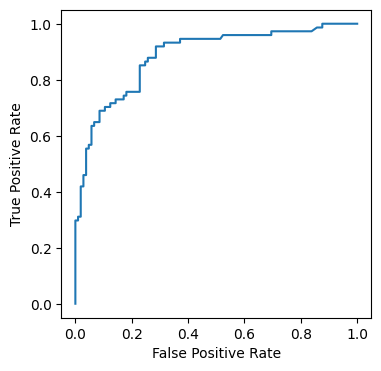

In [38]:
plt.figure(figsize=(4, 4))
best_thresh_tpfp = roc_threshold(model, X_test, y_test)

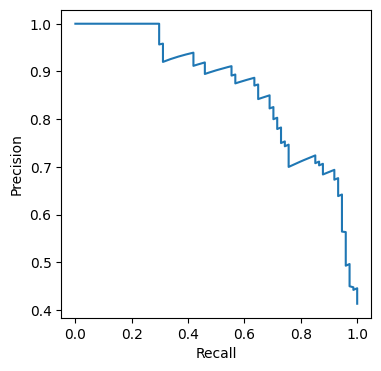

In [37]:
y_proba = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(
    y_test, y_proba, pos_label=1)

plt.figure(figsize=(4, 4))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [27]:
# Optimal threshold for true positive and false positive balance
y_proba = model.predict_proba(X_test)[:, 1]
y_pred = np.where(y_proba > best_thresh_tpfp, 1, 0)
print(f'Threshold={best_thresh_tpfp:.3f}, F1-Score={metrics.f1_score(y_test, y_pred):.3f}')

# Scores
print(metrics.classification_report(y_test, y_pred))

Threshold=0.267, F1-Score=0.784
              precision    recall  f1-score   support

           0       0.91      0.71      0.80       105
           1       0.69      0.91      0.78        74

    accuracy                           0.79       179
   macro avg       0.80      0.81      0.79       179
weighted avg       0.82      0.79      0.79       179



In [31]:
# Optimal threshold for precision and recall balance
thresholds = np.arange(0, 1, 0.01)
scores = []
for t in thresholds:
    y_pred = np.where(y_proba > t, 1, 0)
    scores.append(metrics.f1_score(y_test, y_pred))

# Best threshold
ix = np.argmax(scores)
print(f'Threshold={thresholds[ix]:.3f}, F1-Score={scores[ix]:.3f}')
best_thresh_pr = thresholds[ix]

# Scores
y_pred = np.where(y_proba > best_thresh_pr, 1, 0)
print(metrics.classification_report(y_test, y_pred))

Threshold=0.260, F1-Score=0.786
              precision    recall  f1-score   support

           0       0.93      0.70      0.80       105
           1       0.69      0.92      0.79        74

    accuracy                           0.79       179
   macro avg       0.81      0.81      0.79       179
weighted avg       0.83      0.79      0.79       179



In [34]:
# Run on test dataset
test = pd.read_csv(Path('test.csv'))
y_proba = model.predict_proba(test[features])[:, 1]
y_pred = np.where(y_proba > best_thresh_pr, 1, 0)

# Output
output = pd.DataFrame(
    {'PassengerId': test['PassengerId'], 'Survived': y_pred})
output.to_csv('submission.csv', index=False)

Submission scored 0.71, which is lower than the previous score of 0.77. The decrease seems likely due to the drop in precision for class 1 from 0.84 to 0.69.

Let's try further tuning the decision threshold to find a closer balance in precision and recall for class 1.

In [54]:
# Iterative Tuning
threshold = 0.4
y_proba = model.predict_proba(X_test)[:, 1]
y_pred = np.where(y_proba > threshold, 1, 0)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       105
           1       0.75      0.73      0.74        74

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



In [47]:
# Run on test dataset
test = pd.read_csv(Path('test.csv'))
y_proba = model.predict_proba(test[features])[:, 1]
y_pred = np.where(y_proba > threshold, 1, 0)

# Output
output = pd.DataFrame(
    {'PassengerId': test['PassengerId'], 'Survived': y_pred})
output.to_csv('submission.csv', index=False)

Last submission score was back to 0.77. It appears that threshold tuning does not provide a  significant performance boost in this case.